# ETL_EDA
This file records the process of acquiring raw data, traforming them, and loading them into a MongoDB. The data are store (almost) in their raw form.

In [1]:
import requests
import numpy as np
import pandas as pd
from io import StringIO
import pymongo
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.ticker import FormatStrFormatter, EngFormatter
from matplotlib import cm
# from matplotlib.colors import Normalize
%matplotlib inline

In [2]:
all_states = np.array(['Washington', 'Wisconsin', 'Wyoming', 'Illinois', 'California',
       'Arizona', 'Massachusetts', 'Texas', 'Nebraska', 'Utah', 'Oregon',
       'Florida', 'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Alaska', 'Maine', 'Alabama',
       'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands', 'Guam',
       'West Virginia', 'Northern Mariana Islands'], dtype=object)

## Extract, Transform and Load (ETL)

### 1. Raw Data from New York Times
The [dataset](https://github.com/nytimes/covid-19-data) is a continuously updated txt file in csv format. It contains the covid case and death in the U.S. over time. It includes a cumulative series data at the national, state and county levels.

### 2. Raw Data to Documents/Dicts
Using pandas, it is simple to parse a in-memory string. The first few lines of description need to be skipped. Datetime conversion is made and blank lines are dropped. Now the data can be easily converted to a list of dicts which is what we want for the MongoDB.

### 3. Upsert MongoDB
If we fetch the data frequently, there are lots of duplicate data entry between each run. The de-duplication happens at insertion. The MongoDB API to use is `collection.replace_one(filter=..., replacement=..., upsert=True)`. The statement matches a document in MongoDB with `filter`, replaces it with `replacement` if the document exists or inserts `replacement` into the database if `filter` matches nothing. 

In [3]:
urls = {
    'covid-us': "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv",
    'covid-us-state': "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv",
    'covid-us-county': "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv",
    'mask-use-by-county': "https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv"
}

filters = {
    'covid-us': ['date'],
    'covid-us-state': ['date', 'state'],
    'covid-us-county': ['date', 'county'],
    'mask-use-by-county': ['COUNTYFP']
}

In [4]:
def data_insert(level, url):
    """Request the data from url, and insert the data into
    Mongodb database.
    
    Parameters
    ==========
    level: str
        geographical level for covid tracker
    url: str
        raw data link.
    """
    ## Initialize the Mongodb database
    client = pymongo.MongoClient()
    
    
    ## Raw data from the websites
    req = requests.get(url, timeout=0.5)
    req.raise_for_status()
    text = req.text
    
    ## Raw data to documents/dictionaries.
    df = pd.read_csv(StringIO(text), delimiter=',')
    df.columns = df.columns.str.strip()             # remove space in columns name
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    df.dropna(inplace=True)
    
    ## Upsert MongoDB
    db = client.get_database("covid-us")
    collection = db.get_collection(level)
    update_count = 0
    if level == 'covid-us-county':
        for state in all_states:
            df_state = df[df['state'] == state]
        for record in df_state.to_dict('records'):
            filter_ = {_:record[_] for _ in filters[level]}
            result = collection.replace_one(
                filter=filter_,                             # locate the document if exists
                replacement=record,                         # latest document
                upsert=True)                                # update if exists, insert if not
            if result.matched_count > 0:
                update_count += 1
    else:
        for record in df.to_dict('records'):
            filter_ = {_:record[_] for _ in filters[level]}
            result = collection.replace_one(
                filter=filter_,                             # locate the document if exists
                replacement=record,                         # latest document
                upsert=True)                                # update if exists, insert if not
            if result.matched_count > 0:
                update_count += 1
    print(f"{level.split('-')[-1]}:",
          f"rows={df.shape[0]}, update={update_count}, "
          f"insert={df.shape[0]-update_count}")

Web scrape the data and insert the data into Mongoda database.

In [5]:
%%time
for level, url in urls.items():
    data_insert(level, url)

us: rows=318, update=317, insert=1
state: rows=15194, update=15139, insert=55
county: rows=769835, update=284, insert=769551
county: rows=3142, update=3142, insert=0
CPU times: user 7.26 s, sys: 393 ms, total: 7.65 s
Wall time: 1min 23s


## Exploratory data analysis (EDA)

### Total positive cases and deaths over time

In [6]:
client = pymongo.MongoClient()
db = client.get_database("covid-us")
collection = db.get_collection("covid-us")
data = list(collection.find())
df = pd.DataFrame.from_records(data)    
df.drop('_id', axis=1, inplace=True)
df.tail()

,date,cases,deaths
313,2020-11-29,13448002,266758
314,2020-11-30,13615806,268023
315,2020-12-01,13800086,270633
316,2020-12-02,14000558,273518
317,2020-12-03,14217106,276375


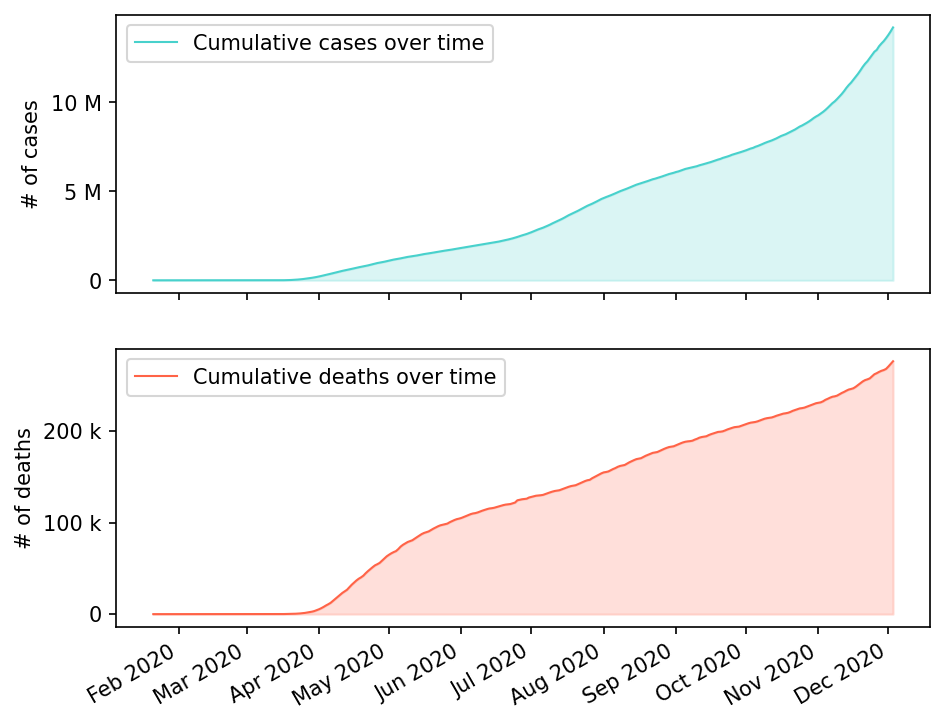

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), dpi=150, sharex=True)
ax1.plot(df.date.values, df.cases.values, linestyle='-', color='mediumturquoise', linewidth=1, 
         label='Cumulative cases over time')
ax2.plot(df.date.values, df.deaths.values, linestyle='-', color='tomato', linewidth=1,
         label='Cumulative deaths over time')

# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%b %Y')
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_formatter(EngFormatter())
ax2.yaxis.set_major_formatter(EngFormatter())
ax1.set_ylabel('# of cases')
ax2.set_ylabel('# of deaths')
# add shaded area
ax1.fill_between(df.date, 0, df.cases, color='mediumturquoise', alpha=0.2)
ax2.fill_between(df.date, 0, df.deaths, color='tomato', alpha=0.2)
ax1.legend()
ax2.legend(loc=2);

### Daily new positive cases and deaths

In [8]:
### The following two utility functions are 
### adpated from the kernel by kaggle.com/therealcyberlord
def daily_increase(data):
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size=7):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

new_daily_cases = daily_increase(df.cases)
new_daily_deaths = daily_increase(df.deaths)

window_size = 7
weekly_avg_cases = moving_average(new_daily_cases)
weekly_avg_deaths = moving_average(new_daily_deaths)

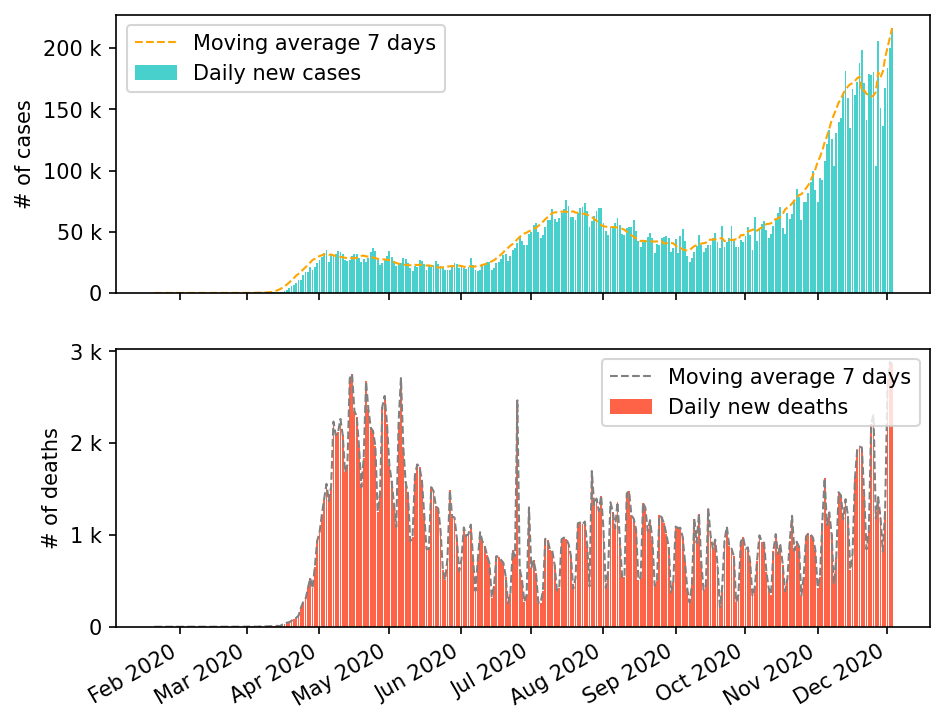

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), dpi=150, sharex=True)
ax1.bar(df.date.values, new_daily_cases, linestyle='-', color='mediumturquoise', linewidth=1, 
         label='Daily new cases')
ax1.plot(df.date.values, weekly_avg_cases, linestyle='--', color='orange', linewidth=1, 
         label='Moving average 7 days')
ax2.bar(df.date.values, new_daily_deaths, color='tomato',
         label='Daily new deaths')
ax2.plot(df.date.values, new_daily_deaths, linestyle='--', color='grey', linewidth=1,
         label='Moving average 7 days')

# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%b %Y')
ax1.xaxis.set_major_formatter(myFmt)
ax1.yaxis.set_major_formatter(EngFormatter())
ax2.yaxis.set_major_formatter(EngFormatter())
ax1.set_ylabel('# of cases')
ax2.set_ylabel('# of deaths')
ax1.legend()
ax2.legend();

### Latest covid cases and deaths in each state

In [10]:
client = pymongo.MongoClient()
db = client.get_database("covid-us")
collection = db.get_collection("covid-us-state")
data = list(collection.find())
df2 = pd.DataFrame.from_records(data)    
df2.drop('_id', axis=1, inplace=True)
df2.tail()

,date,state,fips,cases,deaths
15189,2020-12-03,Virginia,51,244503,4147
15190,2020-12-03,Washington,53,180125,3040
15191,2020-12-03,West Virginia,54,51025,789
15192,2020-12-03,Wisconsin,55,426534,3781
15193,2020-12-03,Wyoming,56,35078,257


In [11]:
# df2.state.unique()

In [12]:
df_latest = df2[df2.date == max(df2.date)]

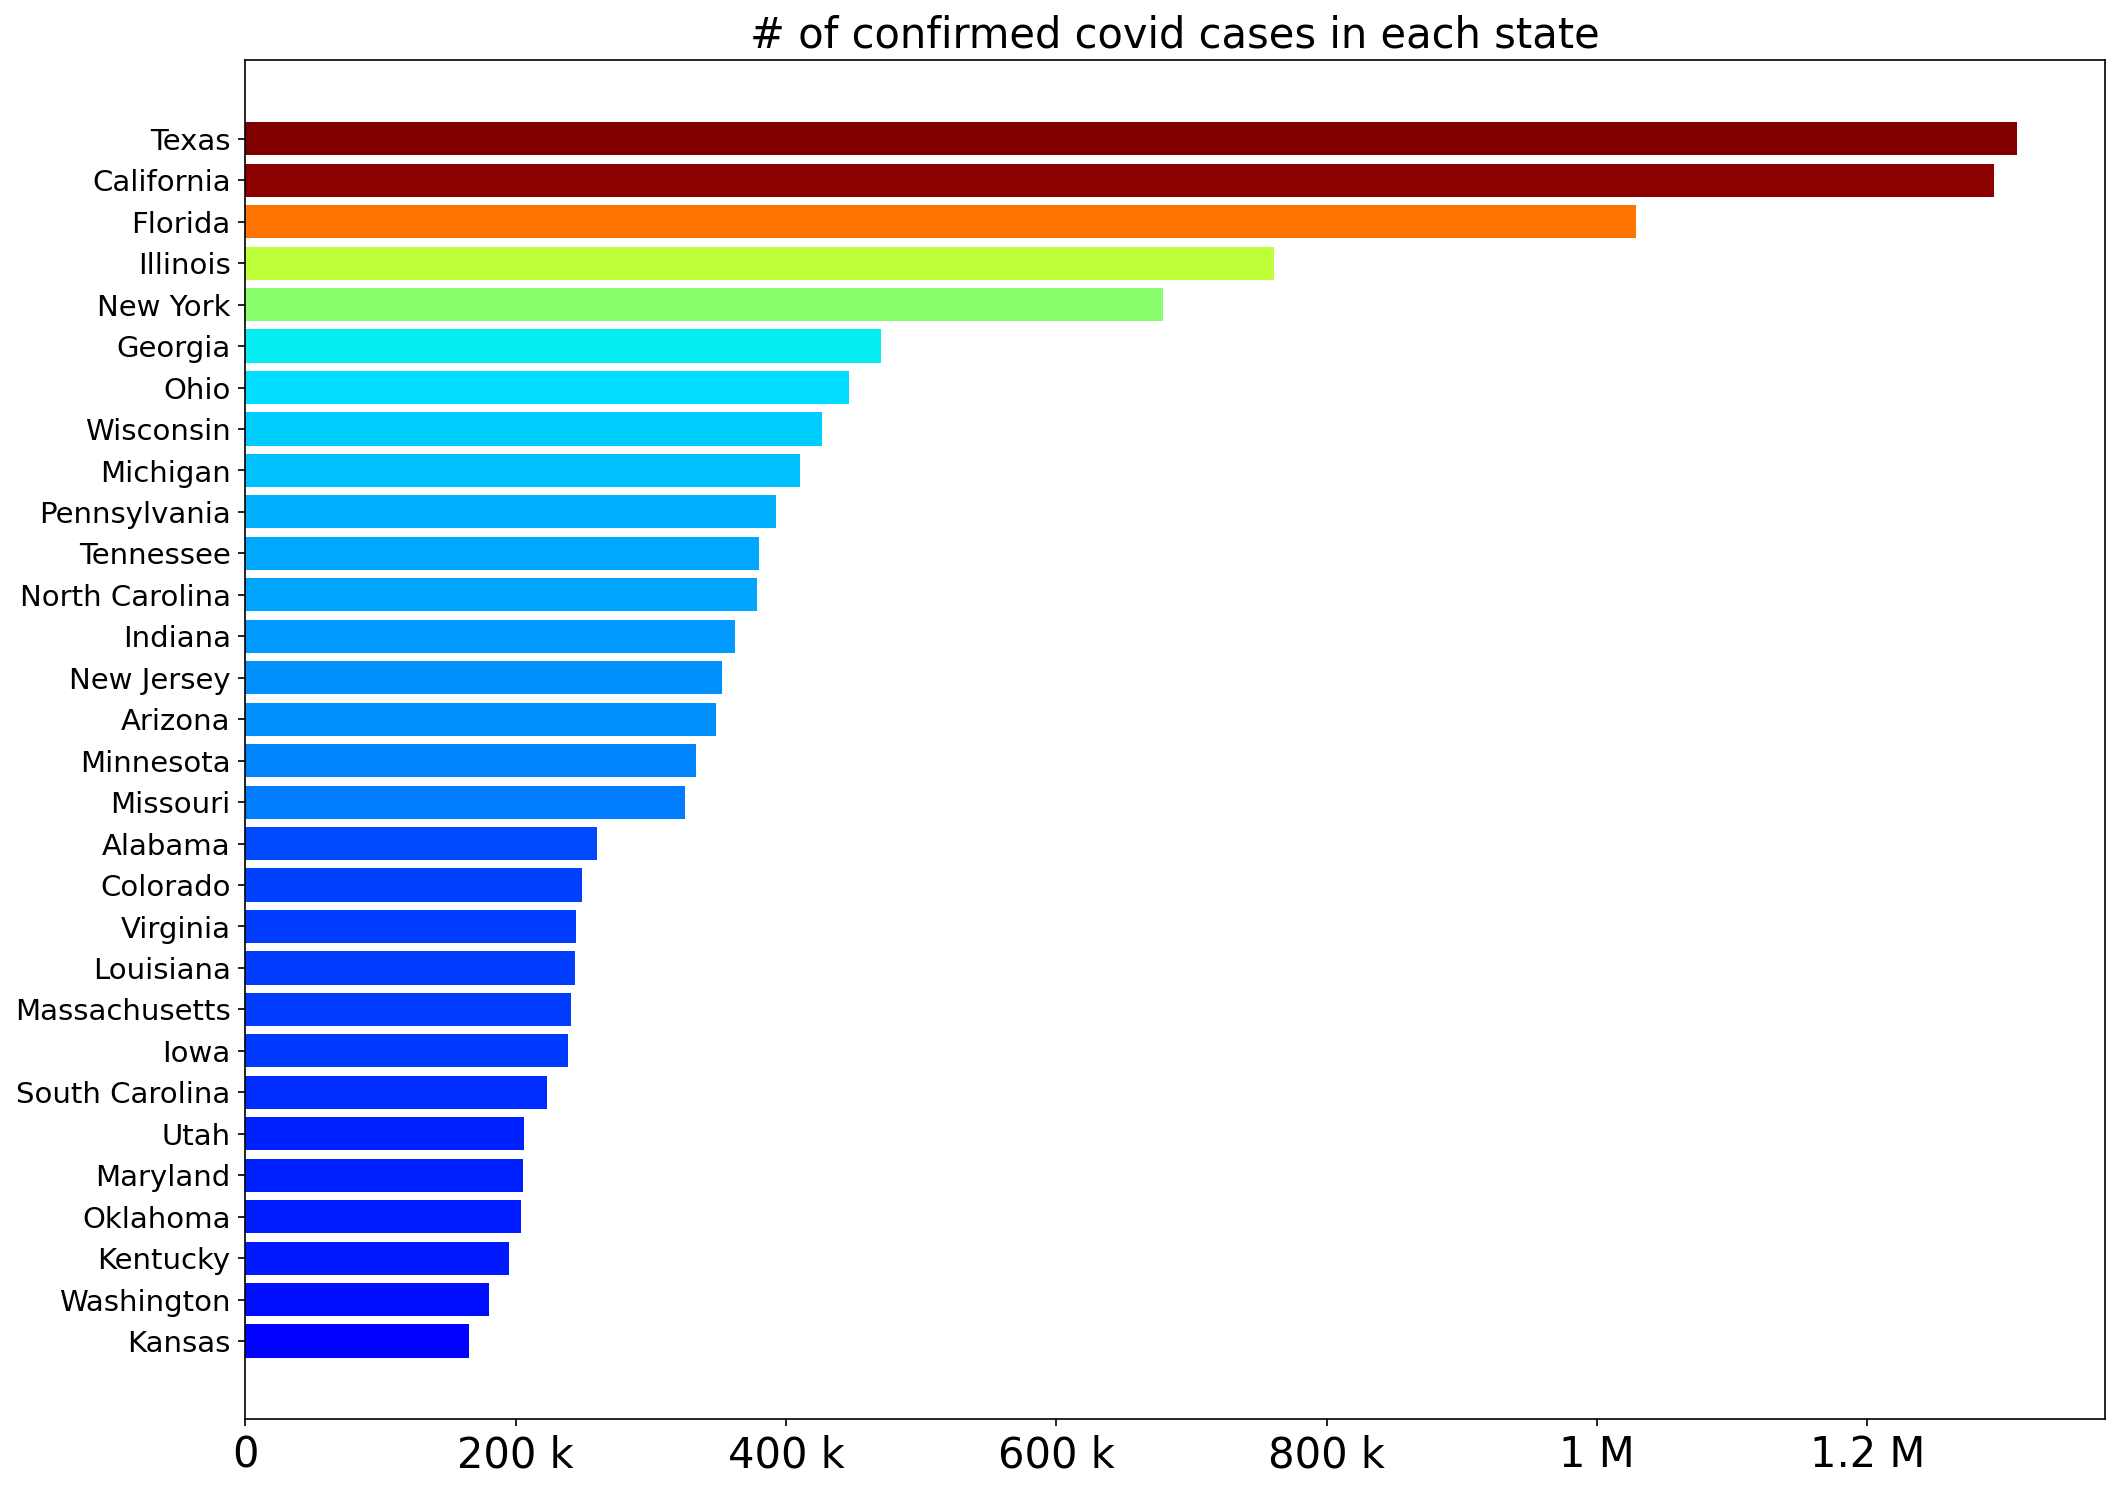

In [13]:
fig, ax = plt.subplots(figsize=(16,12), dpi=150)
cases_sorted, state_sorted_1  = zip(*sorted(zip(df_latest.cases, df_latest.state)))

# Get a color map
my_cmap = cm.get_cmap('jet')

ax.barh(state_sorted_1[-30:], cases_sorted[-30:], 
        color=my_cmap(np.array(cases_sorted[-30:])/max(cases_sorted)))
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=20)
# ax.set_yticks(size=20)
ax.xaxis.set_major_formatter(EngFormatter())
ax.set_title('# of confirmed covid cases in each state', size=20);

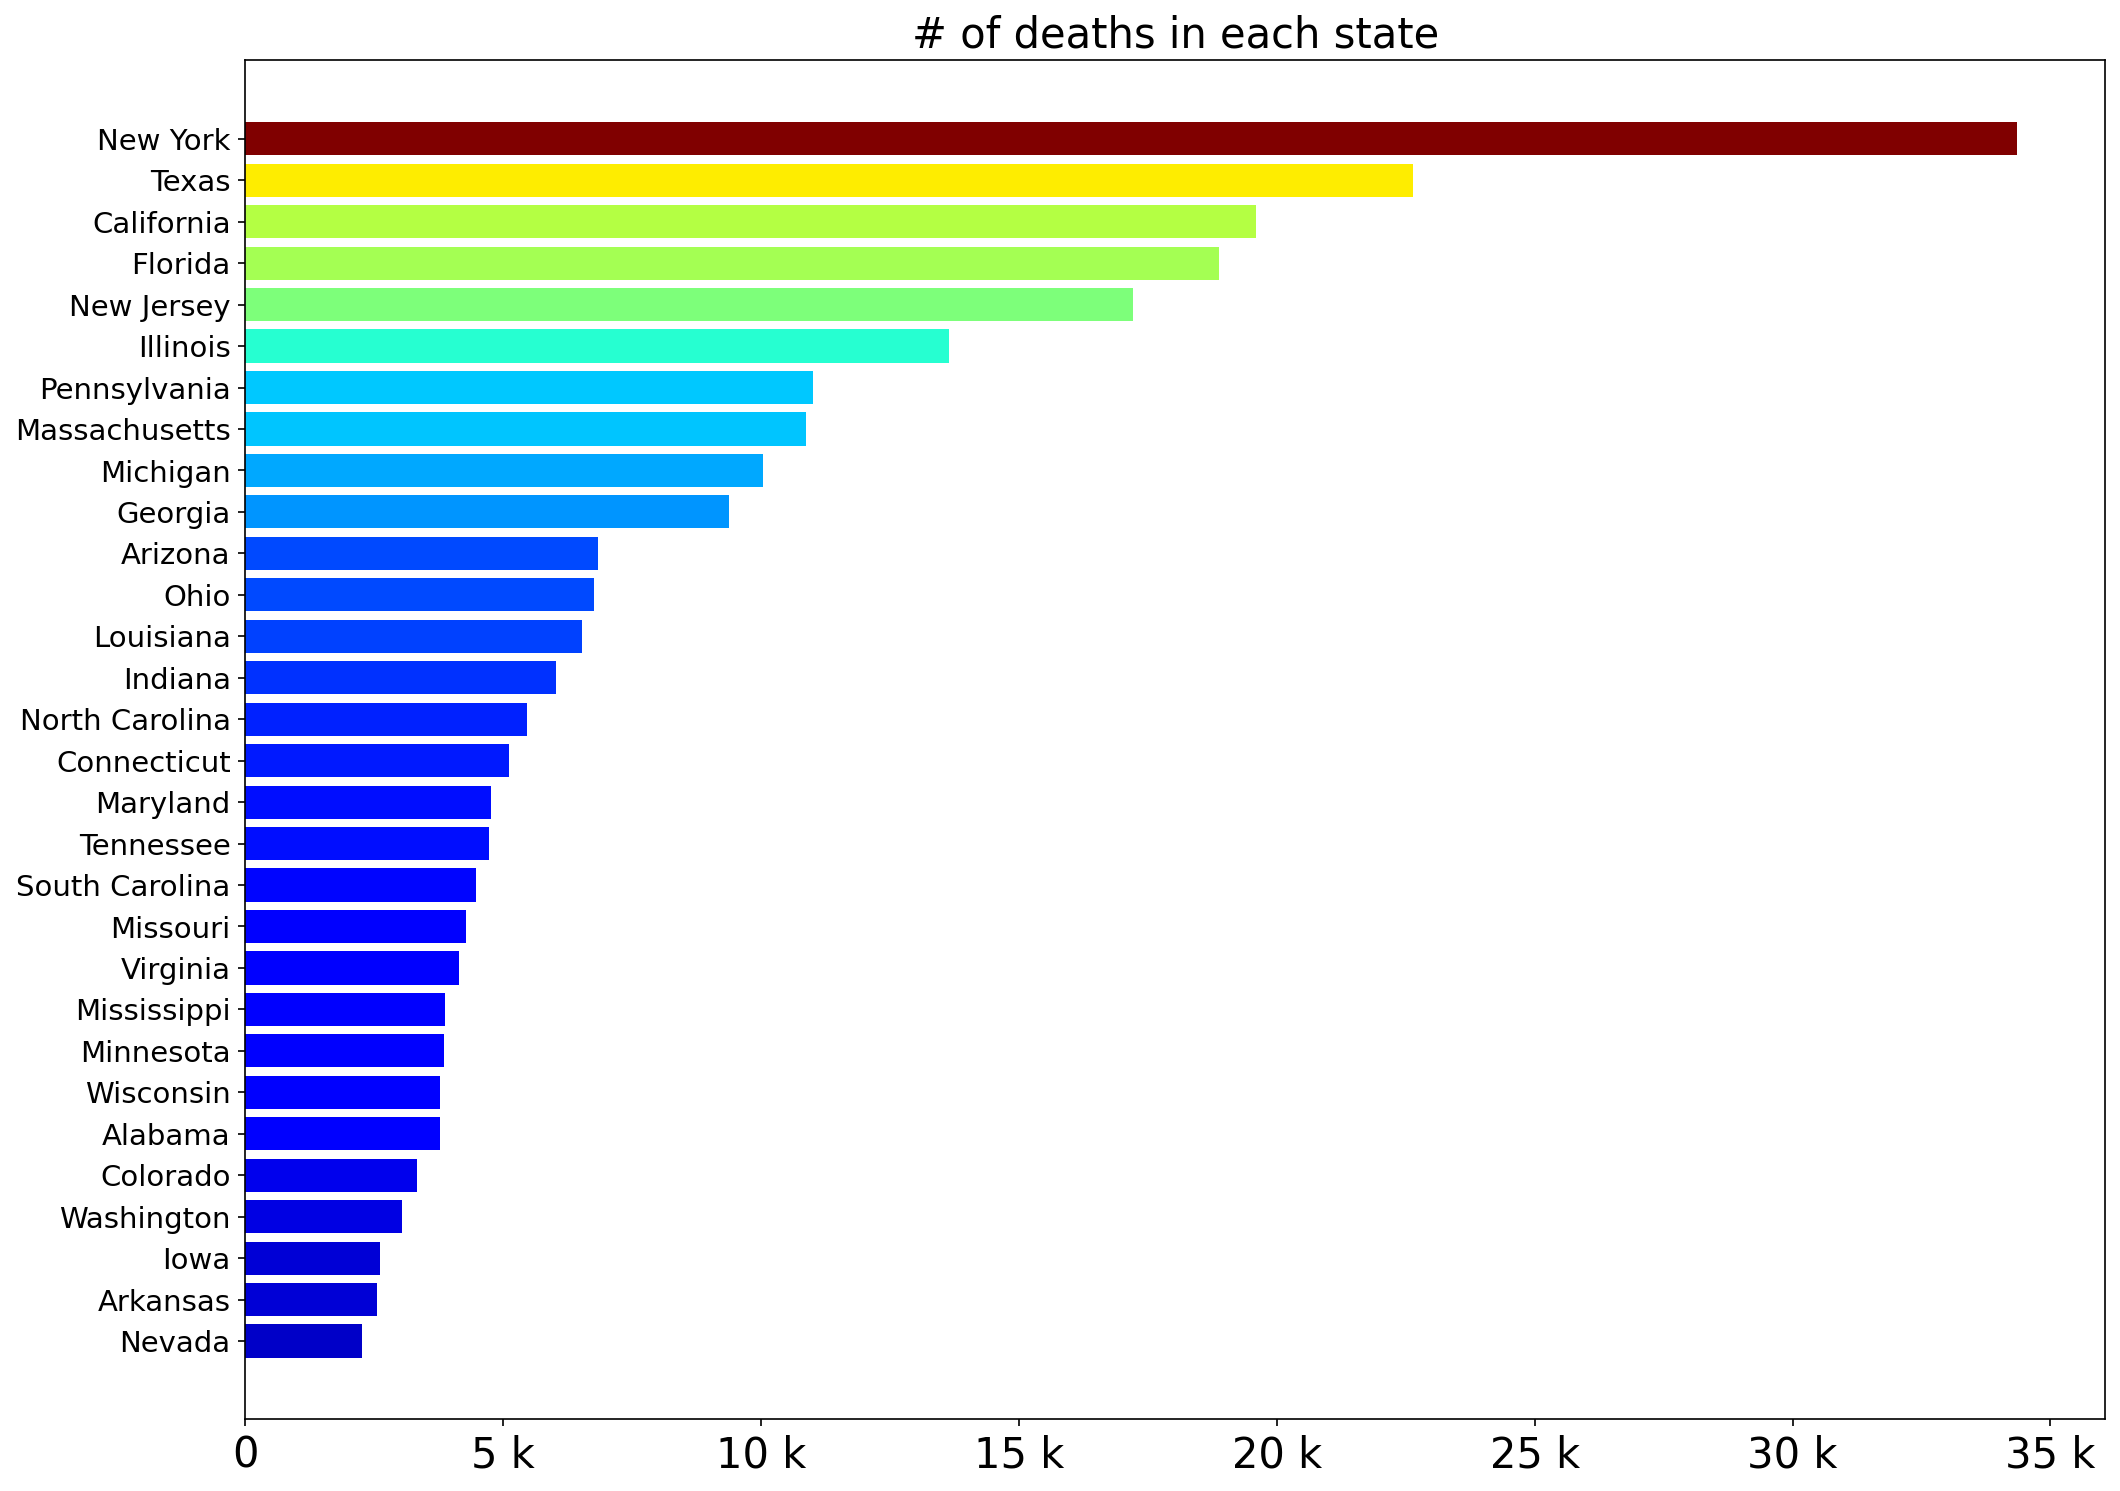

In [14]:
fig, ax = plt.subplots(figsize=(16,12), dpi=150)
deaths_sorted, state_sorted_2  = zip(*sorted(zip(df_latest.deaths, df_latest.state)))
ax.barh(state_sorted_2[-30:], deaths_sorted[-30:], 
       color=my_cmap(np.array(deaths_sorted[-30:])/max(deaths_sorted)))
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=20)
ax.xaxis.set_major_formatter(EngFormatter())
ax.set_title('# of deaths in each state', size=20);

### Covid cumulative cases and deaths in each state over time

In [15]:
from datetime import datetime
maxs = {
    'cases': df2.cases.max(),
    'deaths': df2.deaths.max(),
}
colors = {
    'cases': 'crimson',
    'deaths': 'grey'
}
def plot_total(i, ax,  df, state, label):
    df_state = df[df.state == state]
    x = df_state.date.values
    y = df_state[label].values
    ax.plot(x, y, color=colors[label])
    ax.fill_between(x, 0, y, alpha=0.2, color=colors[label])
    ax.axis('off')
    ax.set_ylim([0, maxs[label]])
    eng_notation = EngFormatter(places=0) 
    ax.text(0.2, 0.85, s=f"{state} ({eng_notation.format_eng(y[-1])})",
            fontsize=16, ha='center', va='center', 
            transform = ax.transAxes)
    if i == 0:
        tick_1 = pd.Timestamp(df_state.date.iloc[0]).strftime("%b %d")
        tick_2 = pd.Timestamp(df_state.date.iloc[-1]).strftime("%b %d")
        ax.text(0, -0.1, s=tick_1, color='grey', fontsize=12,
               transform = ax.transAxes)
        ax.text(0.8, -0.1, s=tick_2, color='grey', fontsize=12,
               transform = ax.transAxes)

In [16]:
states = df2.state.unique()
states_1 = state_sorted_1[-30:][::-1]

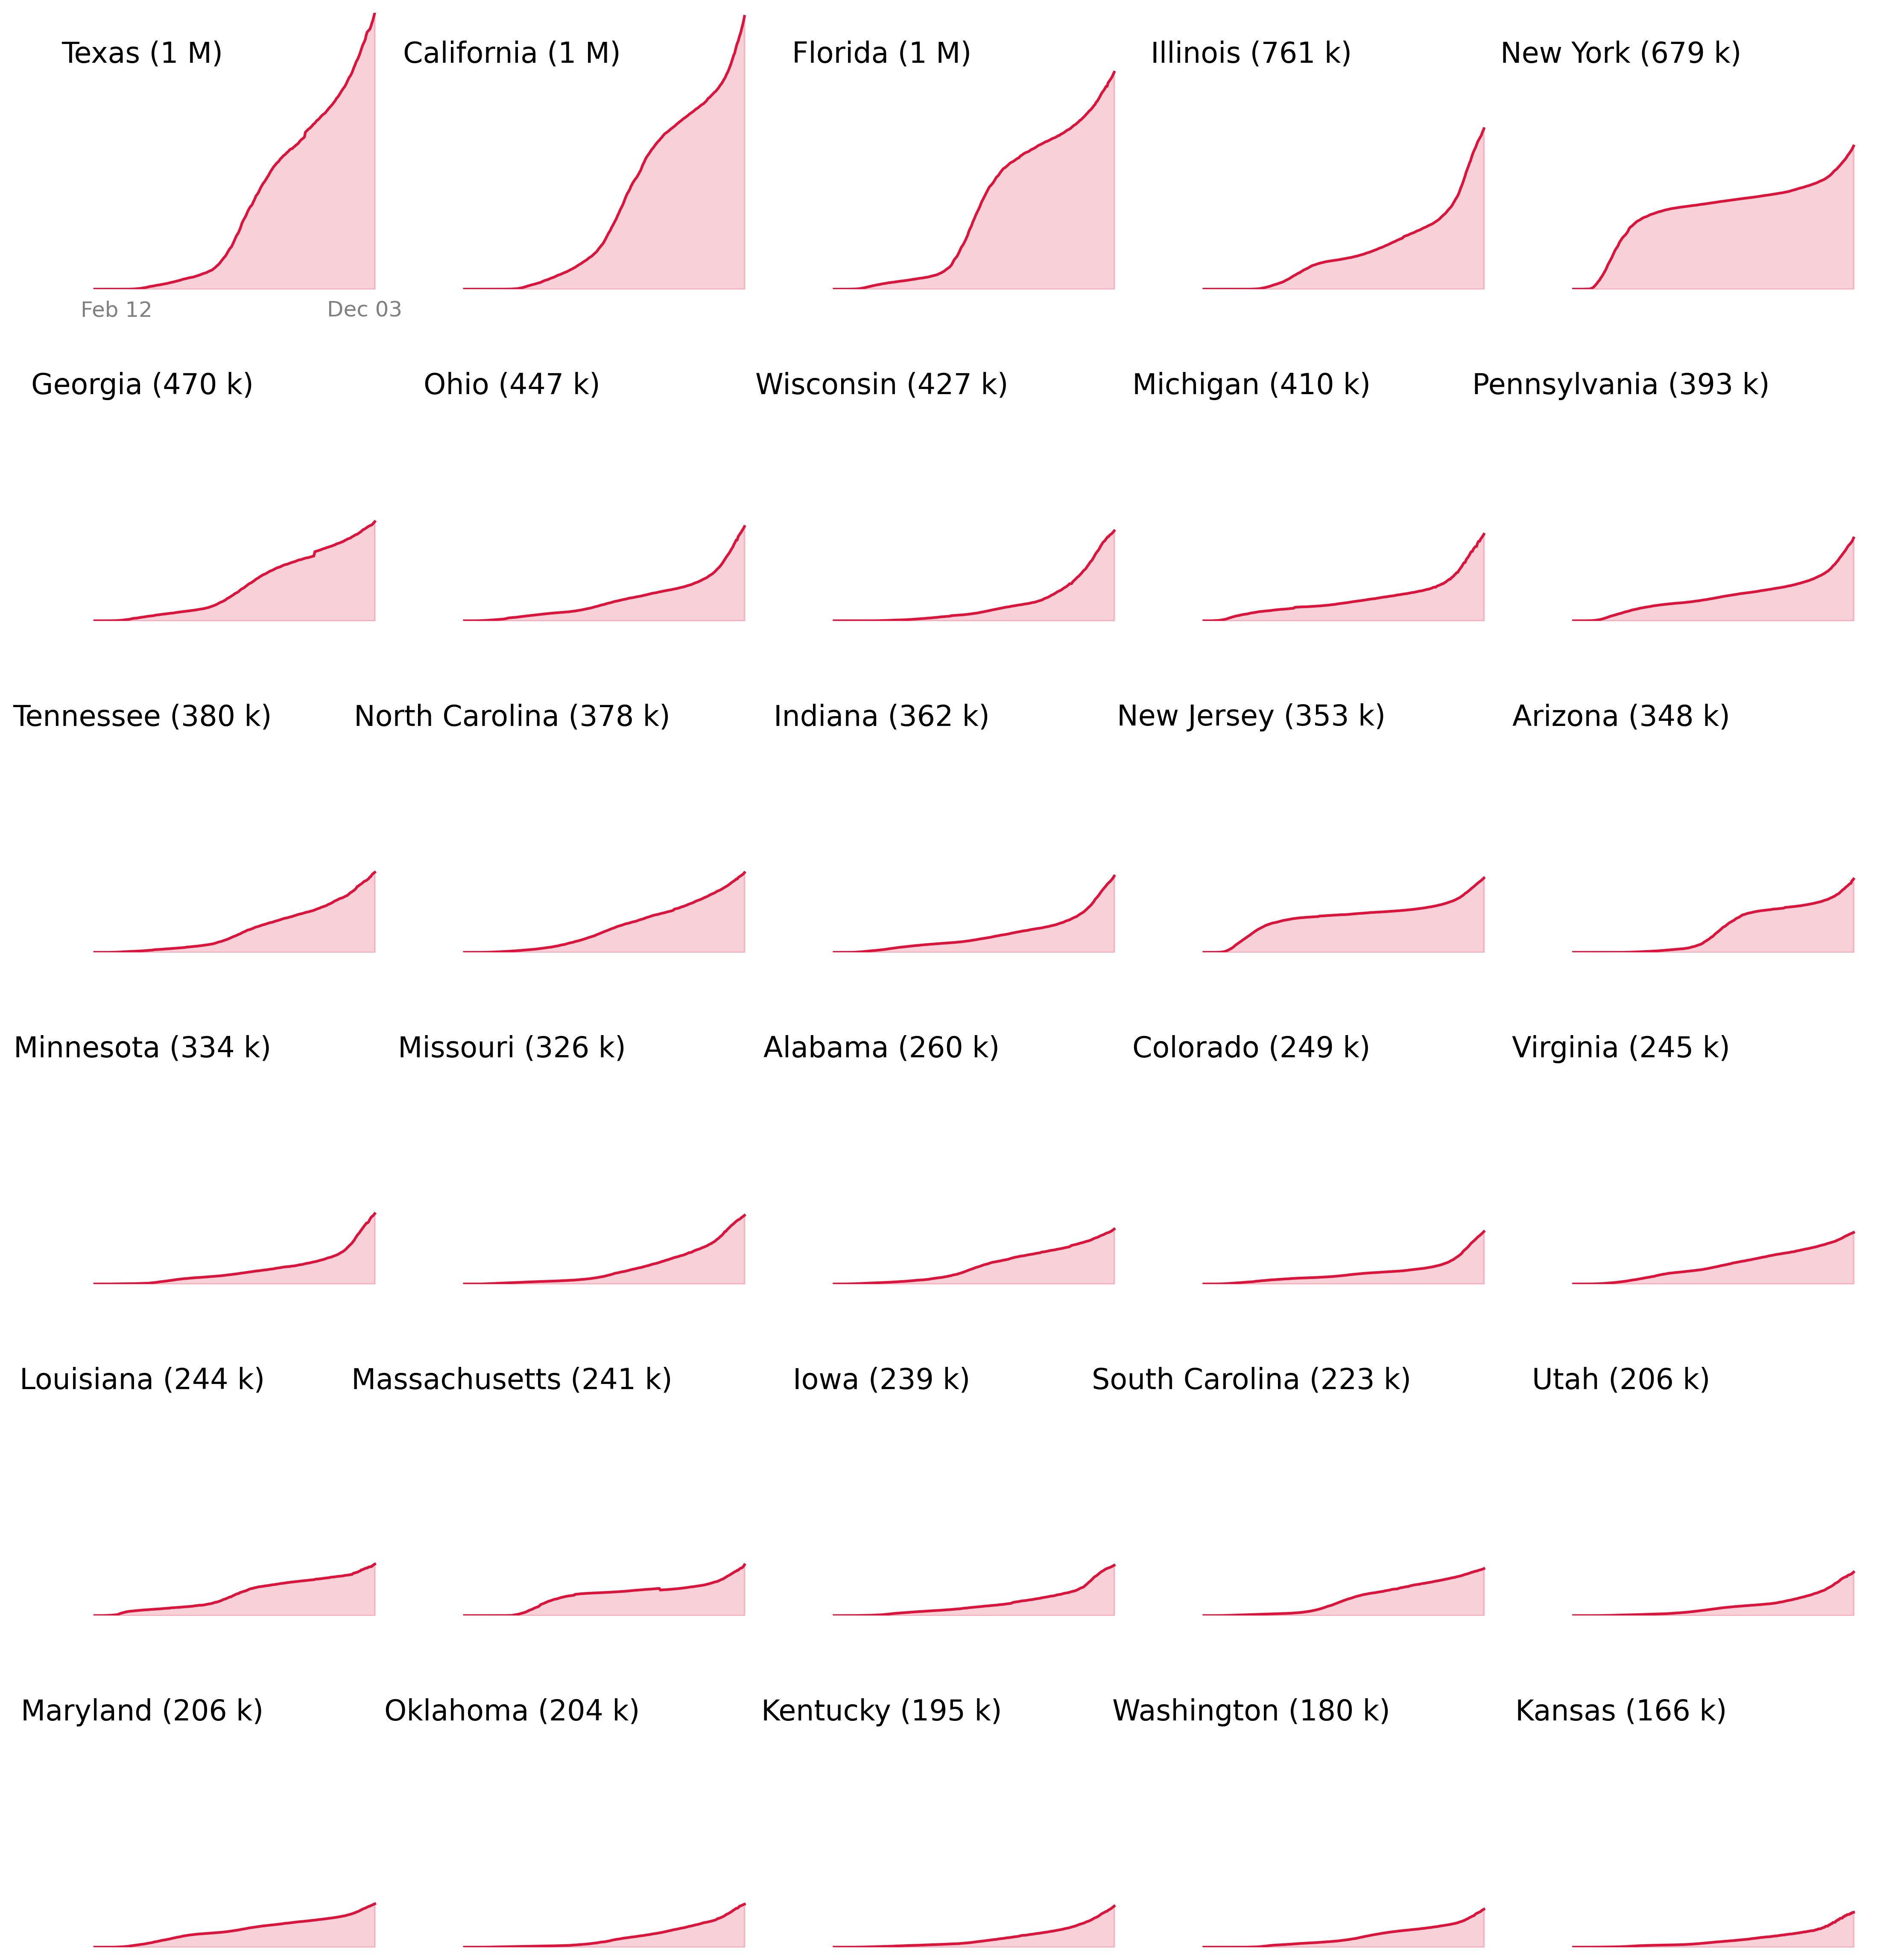

In [17]:
nrows = len(states_1) // 5
plt.figure(figsize=(3*nrows, 20), dpi=300)
for i, state in enumerate(states_1):
    ax = plt.subplot(nrows, 5, i+1)
    plot_total(i, ax, df2, state, label='cases')

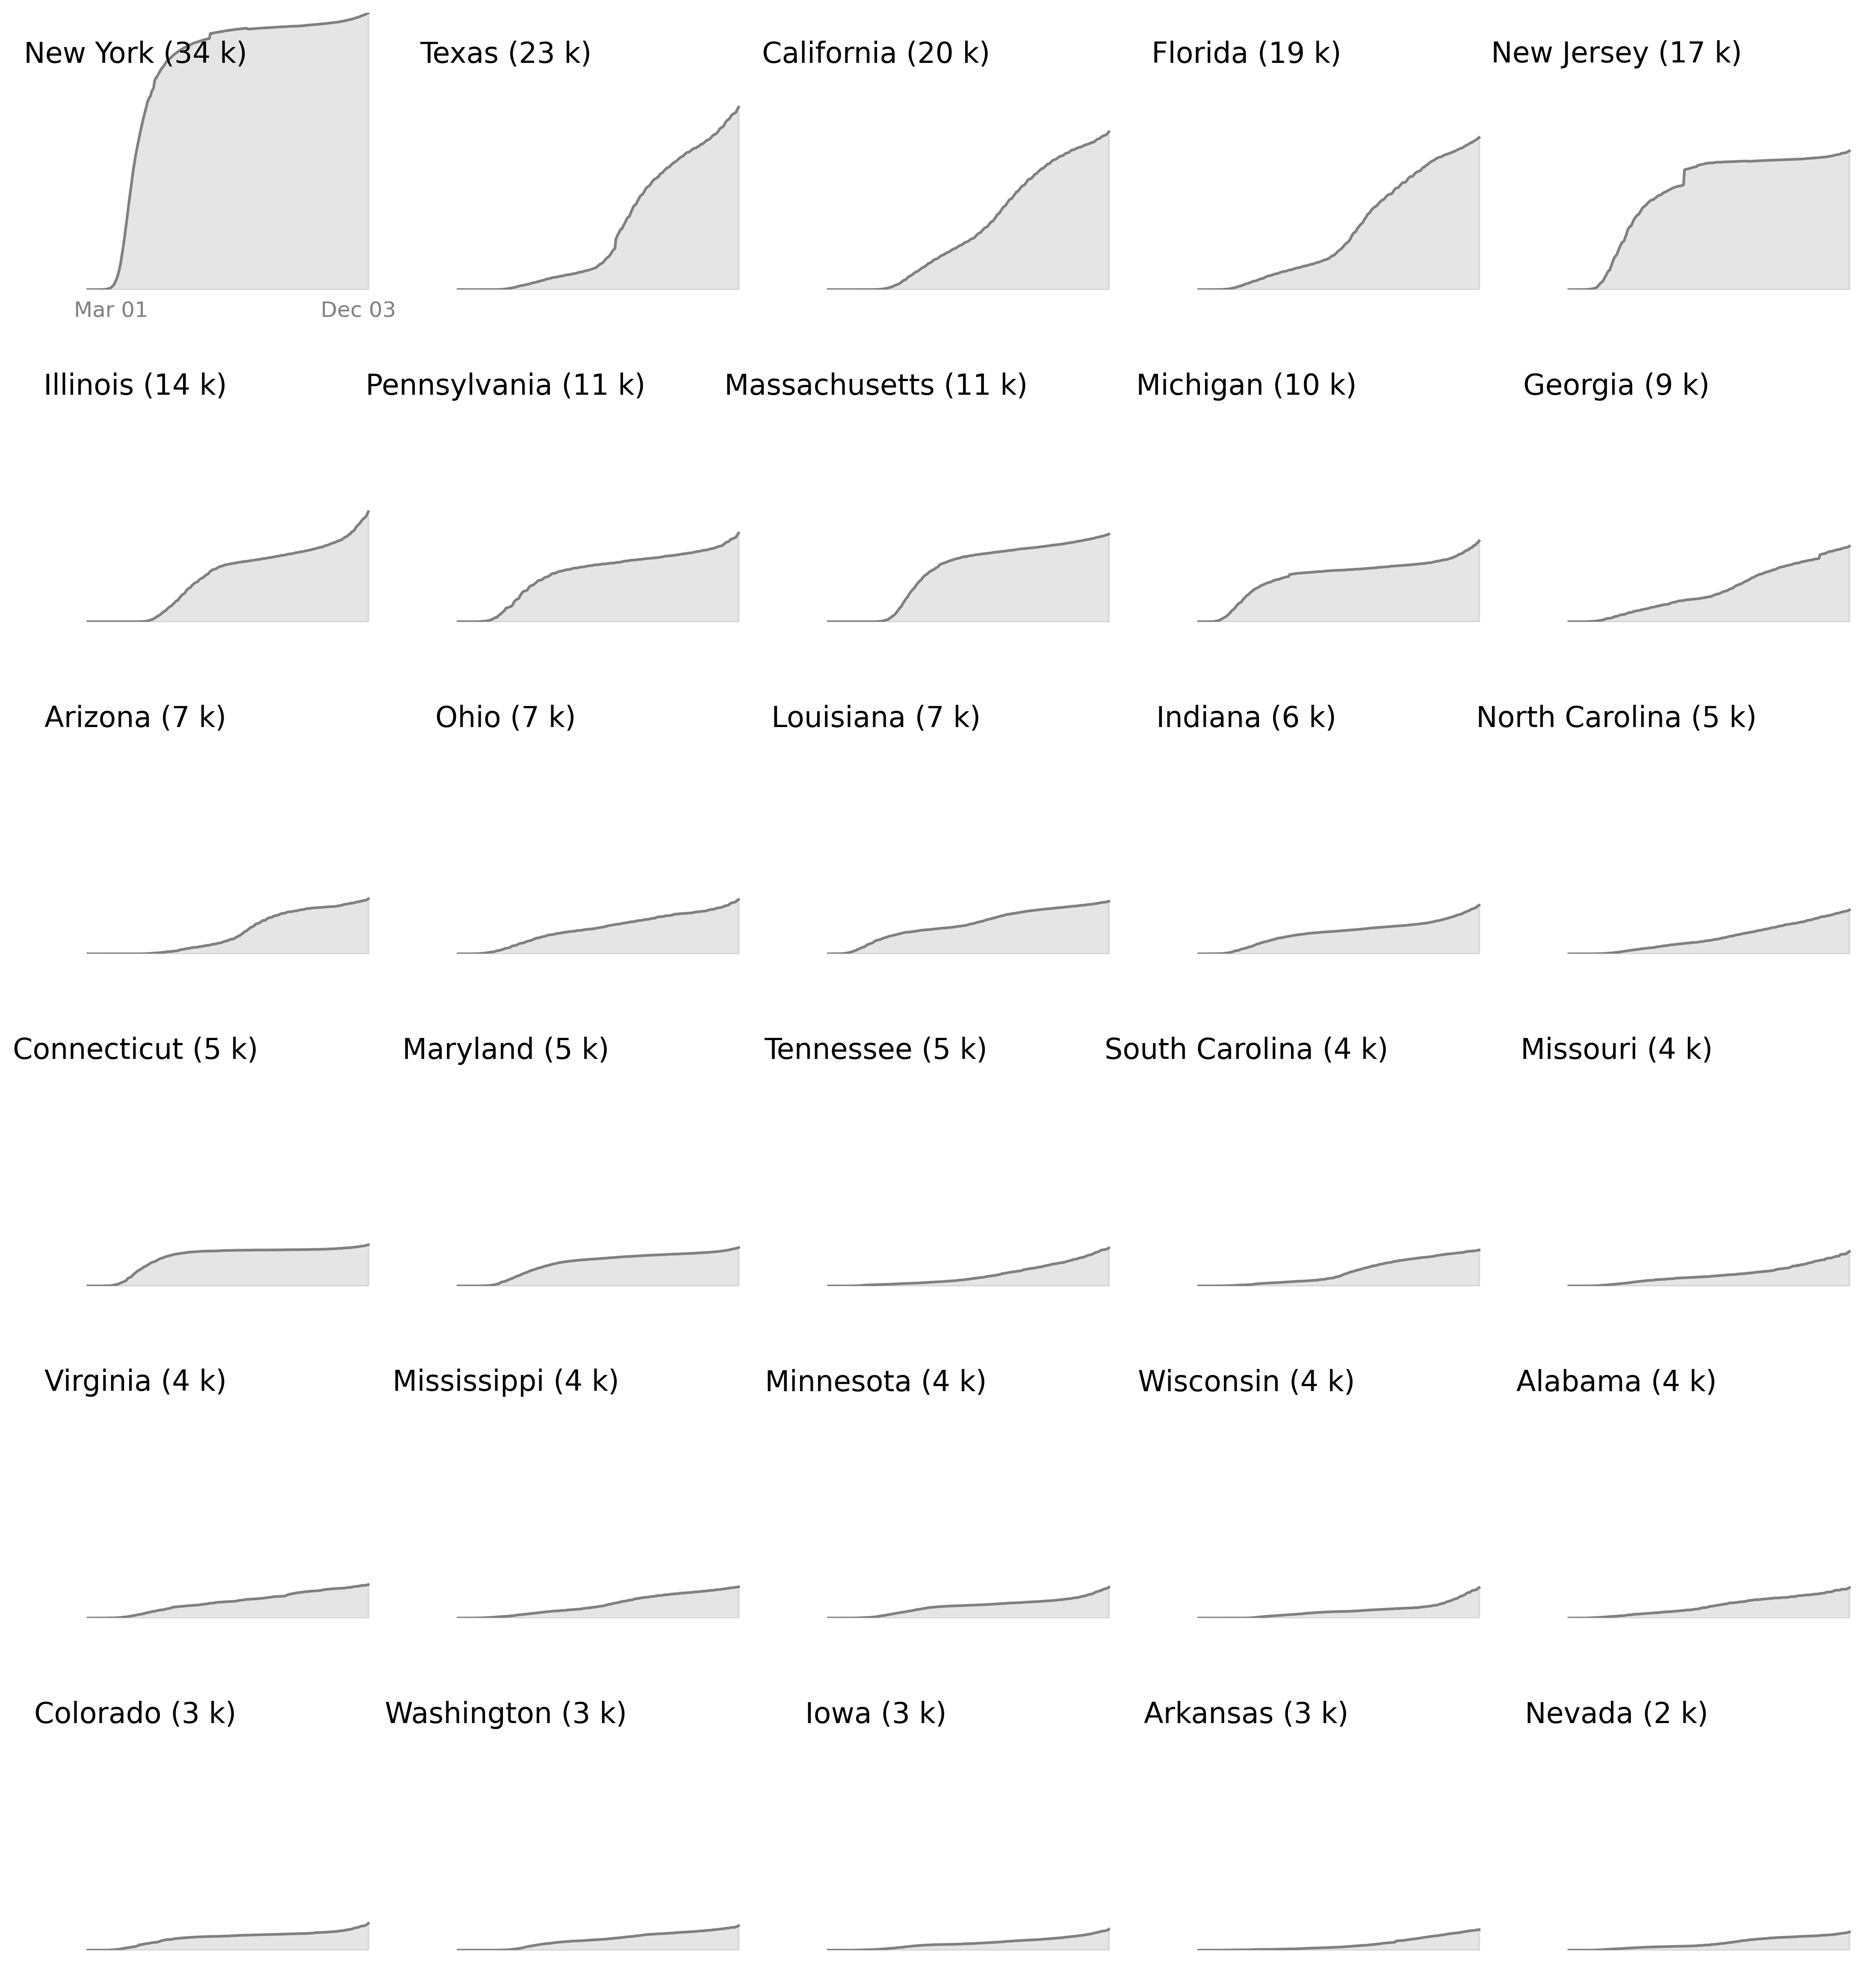

In [18]:
states_2 = state_sorted_2[-30:][::-1]
plt.figure(figsize=(3*nrows, 20), dpi=300)
for i, state in enumerate(states_2):
    ax = plt.subplot(nrows, 5, i+1)
    plot_total(i, ax, df2, state, label='deaths')

### Daily reported cases and deaths in each state overtime

In [19]:
colors_bar = {
    'cases': 'navy',
    'deaths': 'darkgoldenrod'
}
colors_line = {
    'cases': 'crimson',
    'deaths': 'maroon'
}

def plot_daily_and_moving_average(i, ax,  df, state, label, window_size=7):
    df_state = df[df.state == state]
    df_state = df_state.sort_values(by='date')
    x = df_state.date.values
    y = df_state[label].values
    daily_cases = daily_increase(y)
    moving_avg = moving_average(daily_cases, window_size)
    ax.bar(x, daily_cases, color=colors_bar[label])
    ax.plot(x, moving_avg, linestyle='--', color=colors_line[label], linewidth=2)
    ax.axis('off')
    ax.set_ylim([0, max(daily_cases)])
    eng_notation = EngFormatter(places=0) 
    ax.text(0.2, 0.85, s=f"{state} ({eng_notation.format_eng(daily_cases[-1])})",
            fontsize=16, ha='center', va='center', 
            transform = ax.transAxes)
    if i == 0:
        tick_1 = pd.Timestamp(df_state.date.iloc[0]).strftime("%b %d")
        tick_2 = pd.Timestamp(df_state.date.iloc[-1]).strftime("%b %d")
        ax.text(0, -0.1, s=tick_1, color='grey', fontsize=12,
               transform = ax.transAxes)
        ax.text(0.8, -0.1, s=tick_2, color='grey', fontsize=12,
               transform = ax.transAxes)

In [20]:
states = df2.state.unique()
states_1 = state_sorted_1[-30:][::-1]

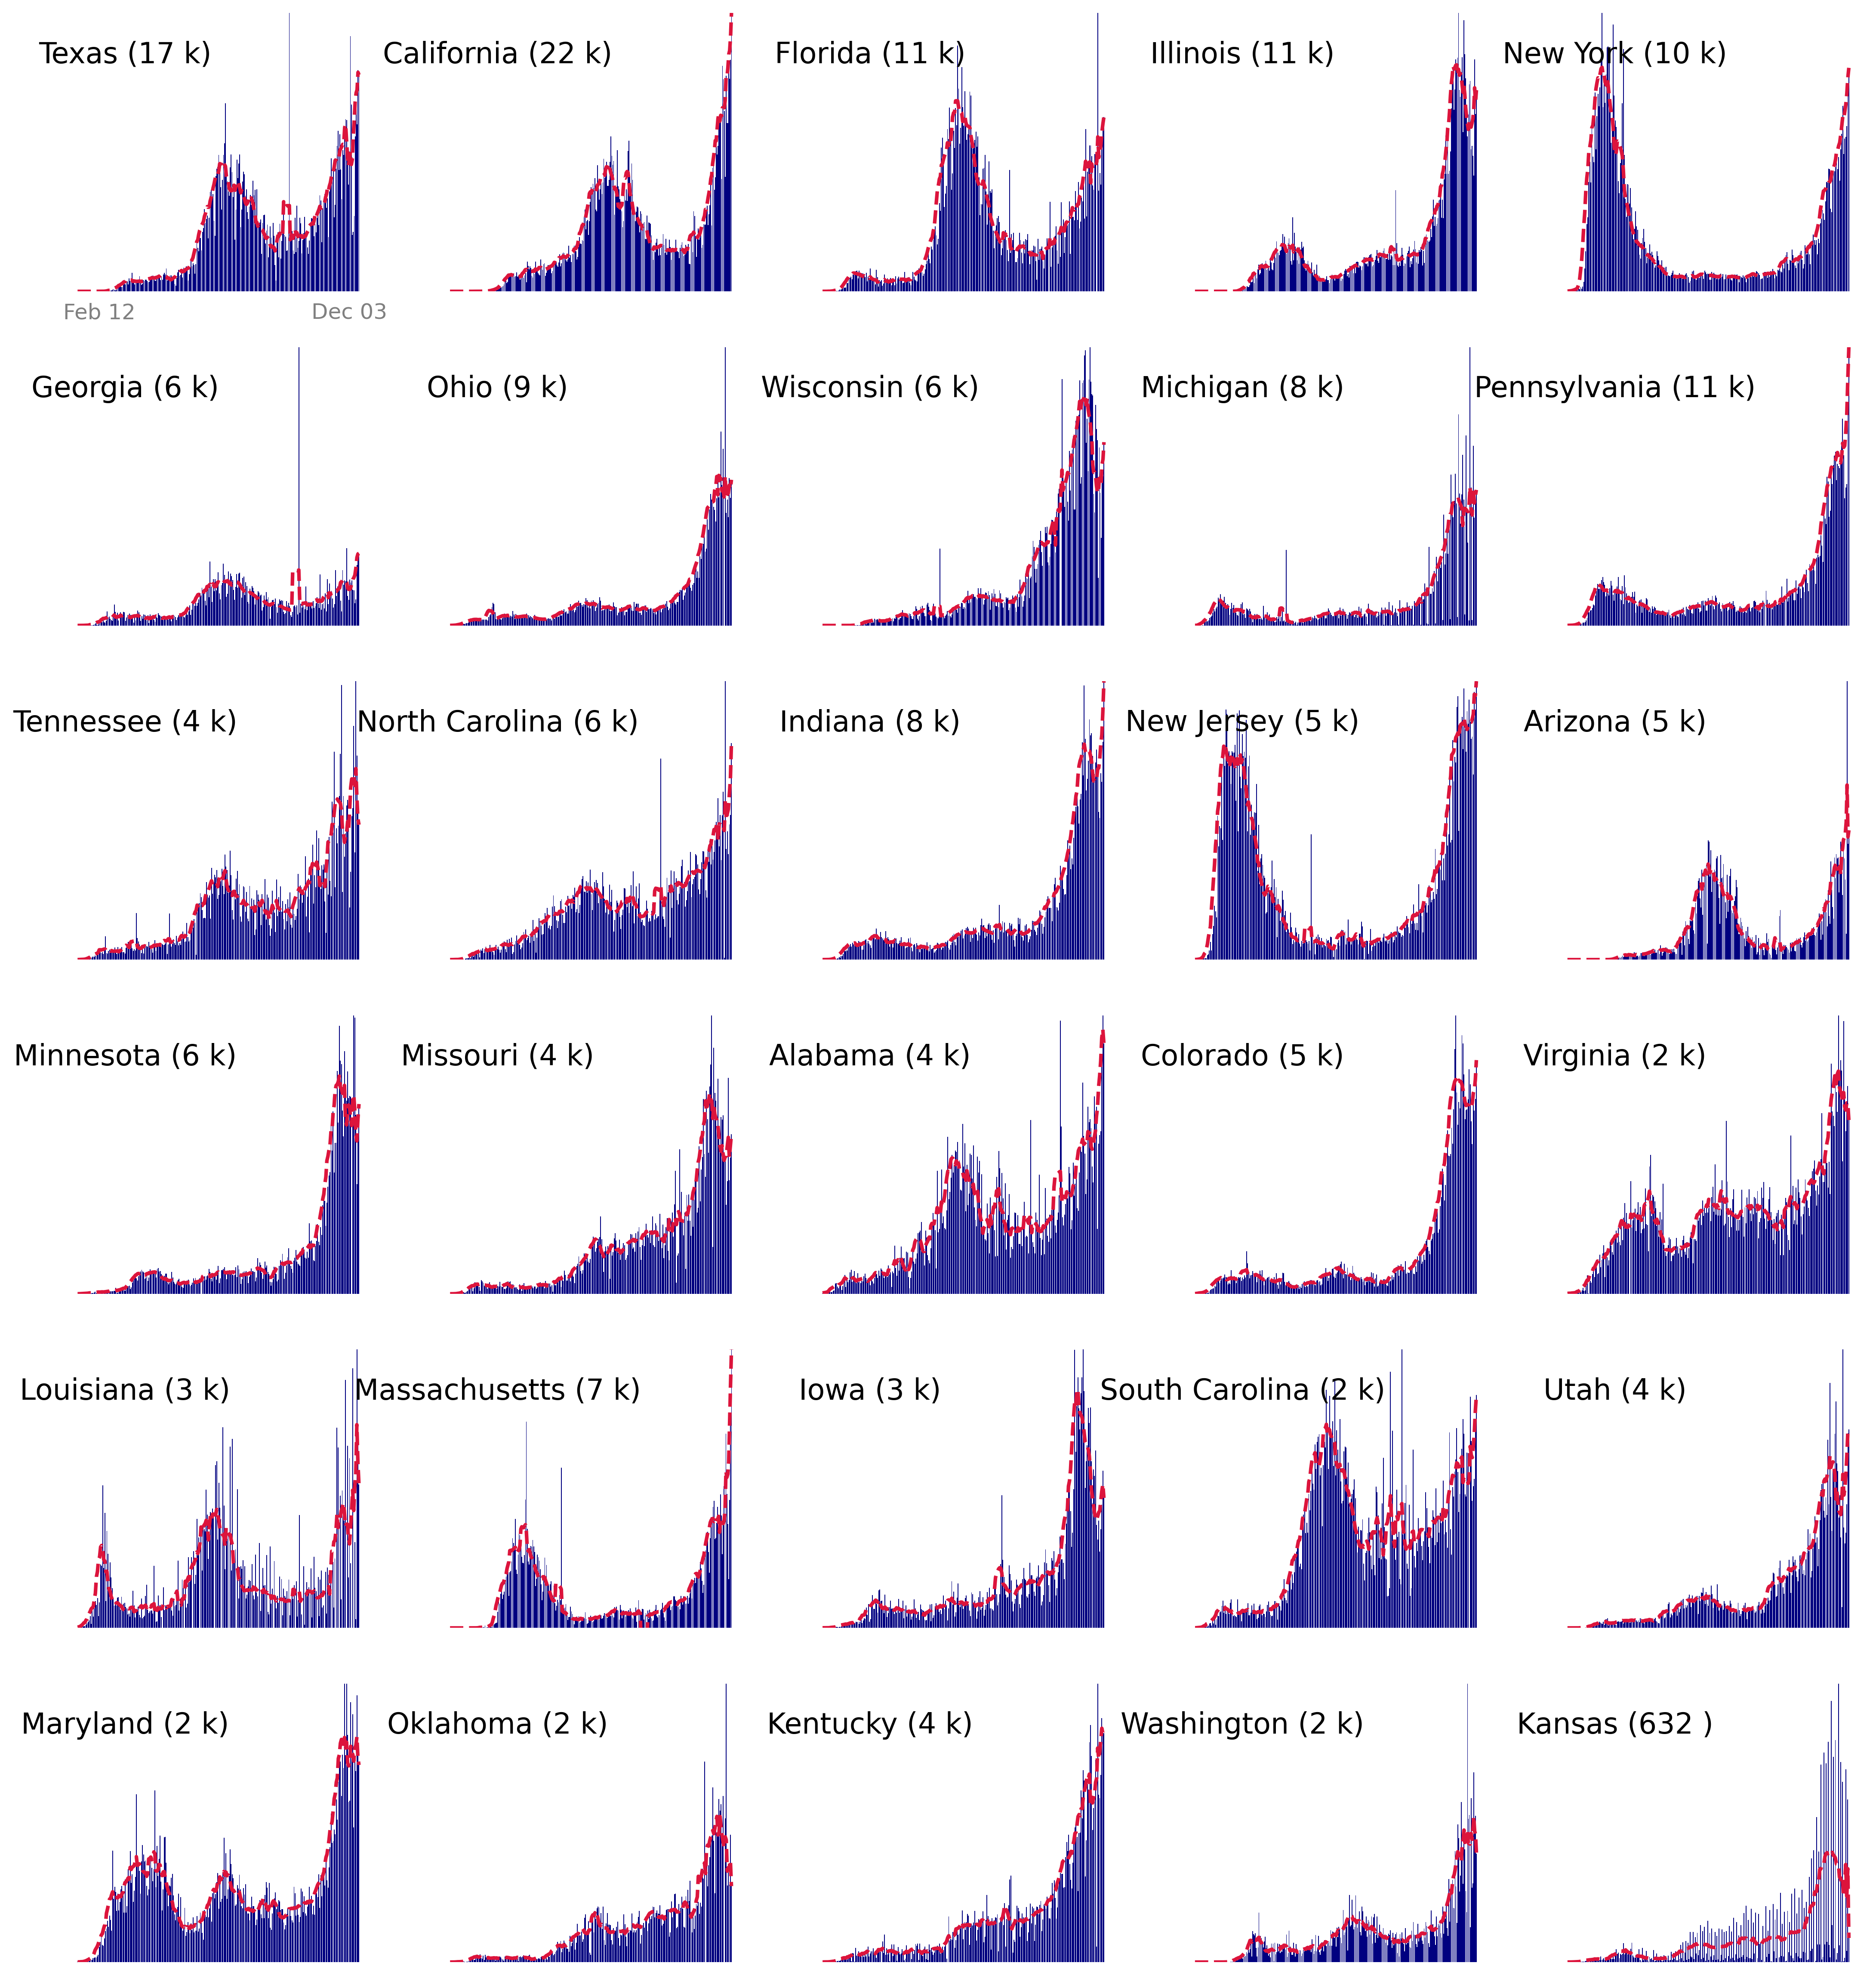

In [21]:
nrows = len(states_1) // 5
plt.figure(figsize=(3*nrows, 20), dpi=300)
for i, state in enumerate(states_1):
    ax = plt.subplot(nrows, 5, i+1)
    plot_daily_and_moving_average(i, ax, df2, state, label='cases')

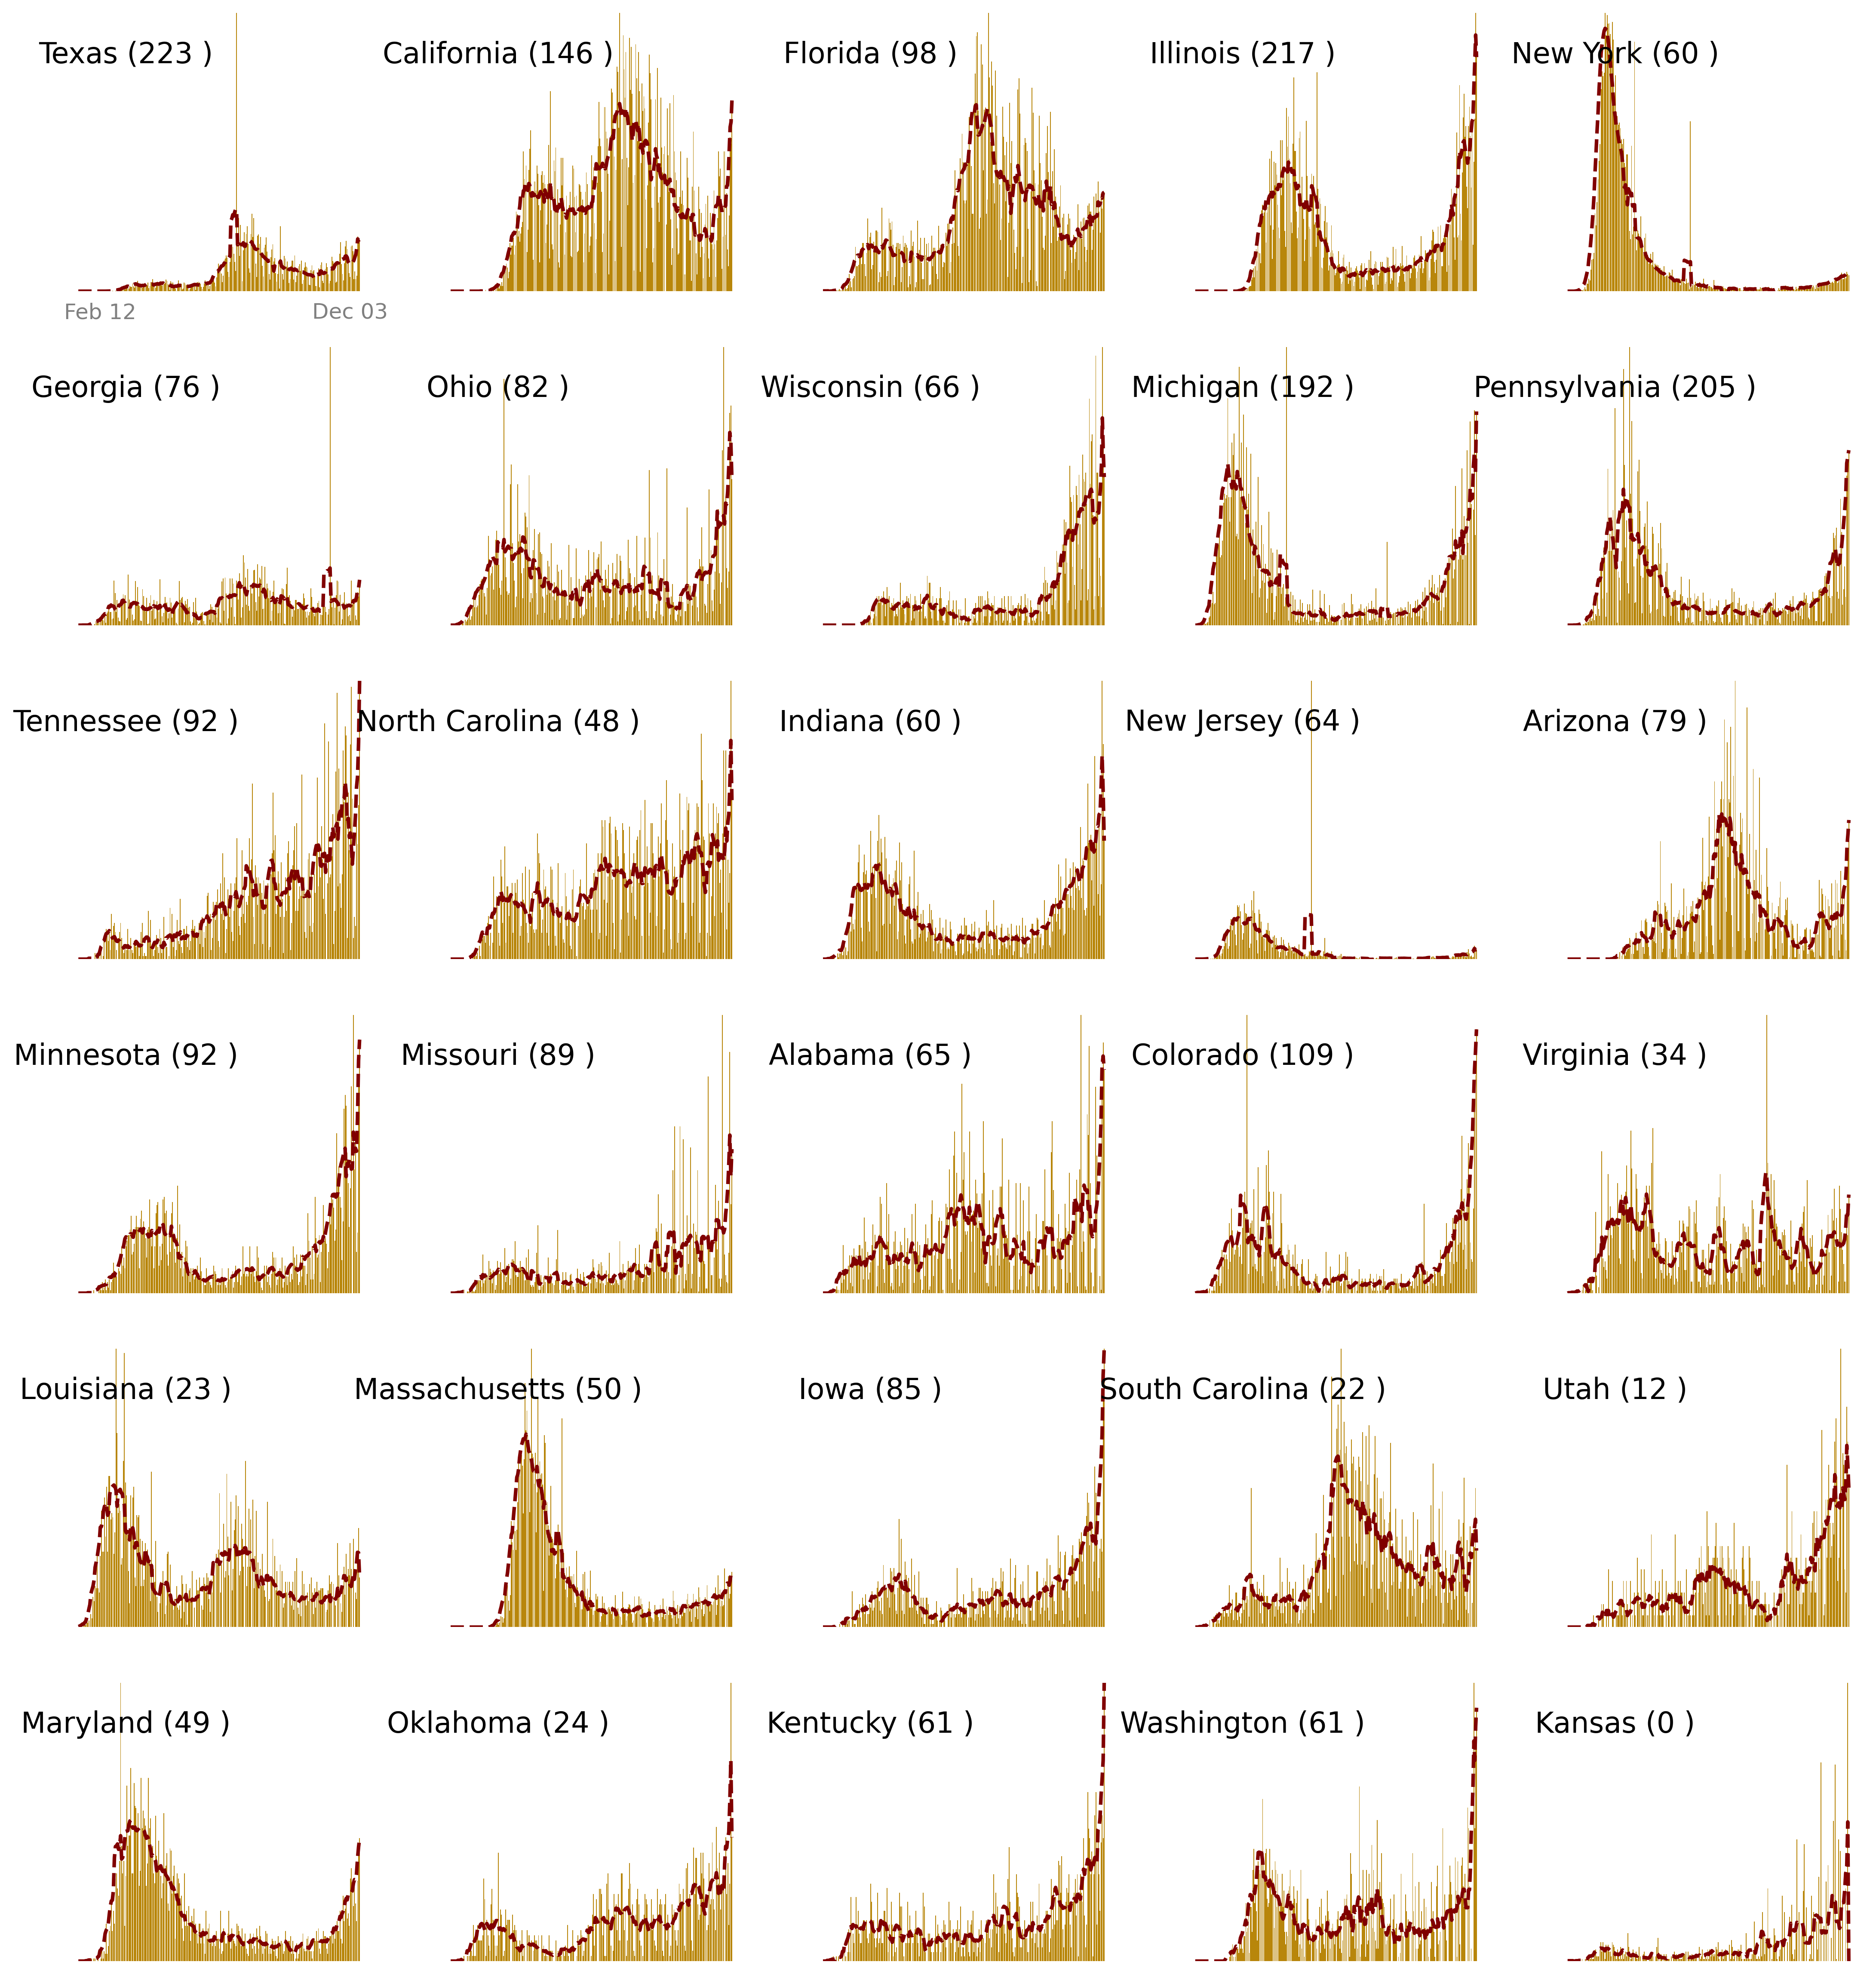

In [22]:
nrows = len(states_1) // 5
plt.figure(figsize=(3*nrows, 20), dpi=300)
for i, state in enumerate(states_1):
    ax = plt.subplot(nrows, 5, i+1)
    plot_daily_and_moving_average(i, ax, df2, state, label='deaths')